In [193]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pyfolio as pf
from zipline.api import (
    order,
    record,
    symbol,
    get_datetime,
    order_target,
    order_target_percent,
    order_target_value,
    set_benchmark,
    get_open_orders,
    set_slippage,
    set_commission,
)
from zipline import run_algorithm
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
import matplotlib.pyplot as plt
import seaborn as sns
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.data.bundles import register, unregister, ingest
from multiprocessing import Pool
from zipline.utils.calendar_utils import get_calendar
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
import yfinance as yf
import quantstats as qs
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from scipy import stats
from zipline import run_algorithm
import warnings
import os

# Ignore warnings to maintain a clean output
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load Zipline extensions for custom functionality
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)


In [194]:
# Explanation: This section defines functions to calculate and visualize rolling statistics for a given return series.
# The rolling Sharpe ratio, rolling volatility, and portfolio value are calculated and plotted for analysis.

def rolling_sharpe(ret):
    """
    Calculate the rolling Sharpe ratio of a return series.

    Args:
        ret (pd.Series): Time series of returns.

    Returns:
        float: Rolling Sharpe ratio.
    """
    return np.multiply(np.divide(ret.mean(), ret.std()), np.sqrt(252))

def get_rolling_stats(result, r_window):
    """
    Calculate rolling statistics including rolling Sharpe ratio, rolling volatility, and mean portfolio value.

    Args:
        result (pd.DataFrame): DataFrame containing portfolio values.
        r_window (int): Rolling window size.

    Returns:
        pd.DataFrame: Original DataFrame with additional columns for rolling statistics.
        list: List containing rolling mean of Sharpe ratio, mean portfolio value, and rolling mean of volatility.
    """
    result["rolling_sharpe"] = result["portfolio_value"].pct_change().rolling(r_window).apply(rolling_sharpe)
    result["rolling_vol"] = result["portfolio_value"].pct_change().rolling(r_window).std()
    stats = [result.rolling_sharpe.mean(), result.portfolio_value.mean(), result.rolling_vol.mean()]
    return result, stats

def show_rolling_stats(result, r_window):
    """
    Plot rolling Sharpe ratio, rolling volatility, and portfolio value.

    Args:
        result (pd.DataFrame): DataFrame containing portfolio values.
        r_window (int): Rolling window size.

    Returns:
        pd.DataFrame: Original DataFrame with additional columns for rolling statistics.
    """
    result, stats = get_rolling_stats(result, r_window)
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    result['rolling_sharpe'].plot(ax=ax[0], title='Rolling Sharpe Ratio')
    result['rolling_vol'].plot(ax=ax[1], title='Rolling Volatility')
    result['portfolio_value'].plot(ax=ax[2], title='Portfolio Value')
    plt.show()
    return result


## Correlation Analysis for Portfolio Construction

In [195]:
# Explanation: This section of the code focuses on fetching historical price data for a list of assets, calculating the 
#correlation matrix,and identifying the top 5 assets with the highest negative correlations. The goal is to aid in portfolio 
#construction by selecting assets that exhibit negative correlations, potentially providing diversification benefits.

# Define my list of assets
asset_list = [
    'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN',
    'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK-B', 'C', 'CAT',
    'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX',
    'DE', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'EXC', 'F', 'FDX', 'GD', 'GE',
    'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ',
    'JPM', 'KHC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT',
    'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE',
    'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX',
    'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH',
    'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM'
]

# Fetch historical price data
def get_price_data(asset_list, start_date, end_date):
    """
    Retrieve historical adjusted closing prices for a list of assets.

    Args:
        asset_list (list): List of asset symbols.
        start_date (str): Start date for historical data.
        end_date (str): End date for historical data.

    Returns:
        pd.DataFrame: DataFrame containing historical adjusted closing prices.
    """
    data = yf.download(asset_list, start=start_date, end=end_date)
    return data['Adj Close']

# Set start and end dates for historical price data
start_date = '2023-01-01'
end_date = '2023-12-31'

# Get historical price data for each asset
price_data = get_price_data(asset_list, start_date, end_date)

# Calculate the correlation matrix
correlation_matrix = price_data.pct_change().corr()

# Identify the top 5 assets with the highest negative correlations
top_negative_assets = (
    correlation_matrix[correlation_matrix < 0]
    .min()
    .sort_values()
    .index[:5]
    .tolist()
)

# Extract correlation matrix for the top 5 assets with the highest negative correlations
correlation_top_negative_assets = correlation_matrix.loc[top_negative_assets, top_negative_assets]

# Display the correlation matrix for the top 5 assets with the highest negative correlations
print("Correlation Matrix for Top 5 Assets with Highest Negative Correlations:")
print(correlation_top_negative_assets)


[*********************100%%**********************]  101 of 101 completed
Correlation Matrix for Top 5 Assets with Highest Negative Correlations:
           MRK       AMD      META      ABBV      AMZN
MRK   1.000000 -0.134351 -0.074386  0.328155 -0.068167
AMD  -0.134351  1.000000  0.437975 -0.128394  0.489142
META -0.074386  0.437975  1.000000 -0.132259  0.579739
ABBV  0.328155 -0.128394 -0.132259  1.000000 -0.130248
AMZN -0.068167  0.489142  0.579739 -0.130248  1.000000


1. MRK (Merck & Co., Inc.): Healthcare/Pharmaceuticals
2. AMD (Advanced Micro Devices, Inc.): Information Technology/Semiconductors
3. META (Meta Platforms, Inc.): Communication Services/Social Media
4. ABBV (AbbVie Inc.): Healthcare/Pharmaceuticals
5. AMZN (Amazon.com Inc.): Consumer Discretionary/E-Commerce

In [197]:
# Load a pre-defined bundle of assets
bundle = 'multi_asset_snp100'
bundle_data = bundles.load(bundle)

# Define specific assets from the bundle using Security IDs (sids)
sids = (1, 6, 9, 64, 67)
assets = bundle_data.asset_finder.retrieve_all(sids)

# Set the initial capital for the analysis
capital_base = 10_000

# Define the start and end dates for the analysis
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-01-01')

## Bollinger Bands Strategy Implementation

This is a trend-following strategy that uses the Bollinger Bands indicators. In trend following strategy, the bollinger bands can be used to show the price breakouts. So, the strategy goes like this:

1. A buy signal forms if the price break above the upper band.
2. A sell signal forms if the price break below the lower band.

In [198]:
def initialize(context):
    """
    Initialize the trading strategy context.

    Args:
        context (zipline.api.TradingAlgorithm): The trading strategy context.
    """
    context.i = 0
    context.assets = assets
    context.bollinger_window = 5  # Bollinger Bands window
    context.bollinger_dev = 1.5  # Number of standard deviations for Bollinger Bands
    context.max_window = 5

def exec_trade(data, positions):
    """
    Execute trades for the specified positions.

    Args:
        data (zipline.api.BarData): The bar data for the current trading day.
        positions (dict): Dictionary containing asset and target percent for trading.

    Returns:
        None
    """
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

def handle_data(context, data):
    """
    Execute trading logic based on Bollinger Bands signals.

    Args:
        context (zipline.api.TradingAlgorithm): The trading strategy context.
        data (zipline.api.BarData): The bar data for the current trading day.

    Returns:
        None
    """
    context.i += 1
    if context.i < context.max_window:
        return
    buy_signal = False
    sell_signal = False
    
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.max_window + 1, frequency='1d')
        # Calculate Bollinger Bands
        sma = prices[-context.bollinger_window:].mean()
        rolling_std = prices[-context.bollinger_window:].std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            # Generate signals based on Bollinger Bands
            if current_price > upper_band:
                target_percent = 1.0  # Long position
                buy_signal = True
            elif current_price < lower_band:
                target_percent = -1.0  # Short position
                sell_signal = True
            else:
                target_percent = 0.0  # Close position
            
            # Execute the trade based on the target percent
            exec_trade(data, {asset: target_percent})
        
        # Record the values for later analysis
        record(
            price=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices
        )


In [199]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

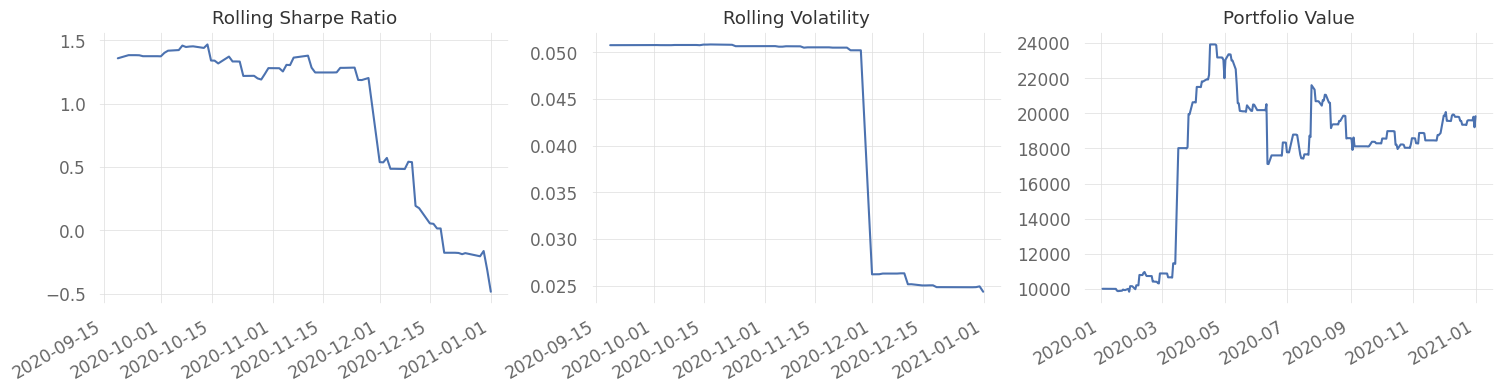

In [200]:
result = show_rolling_stats(result, 180)

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-15   2020-01-15
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       67.0%

Cumulative Return          16.31%       98.39%
CAGR﹪                     11.46%       63.53%

Sharpe                     0.63         1.29
Prob. Sharpe Ratio         72.94%       97.05%
Smart Sharpe               0.61         1.26
Sortino                    0.86         3.65
Smart Sortino              0.84         3.56
Sortino/√2                 0.61         2.58
Smart Sortino/√2           0.59         2.52
Omega                      1.76         1.76

Max Drawdown               -33.72%      -28.5%
Longest DD Days            170          254
Volatility (ann.)          33.97%       70.09%
R^2                        0.06         0.06
Information Ratio          0.05         0.05
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-04-22,2020-06-12,2020-12-31,254,-28.497643,-27.199136
2,2020-02-13,2020-02-26,2020-03-10,27,-5.970715,-5.796246
3,2020-01-31,2020-02-03,2020-02-03,4,-1.716612,-0.050706
4,2020-01-28,2020-01-28,2020-01-28,1,-1.643629,NaN
5,2020-01-16,2020-01-17,2020-01-24,9,-1.278120,-1.041462


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


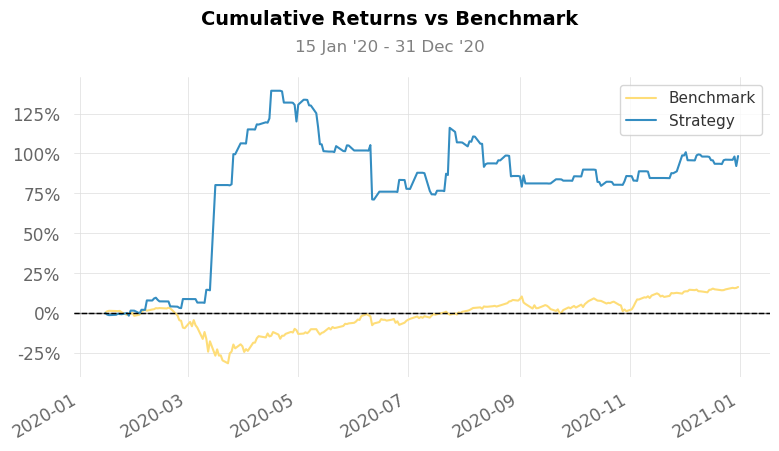

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


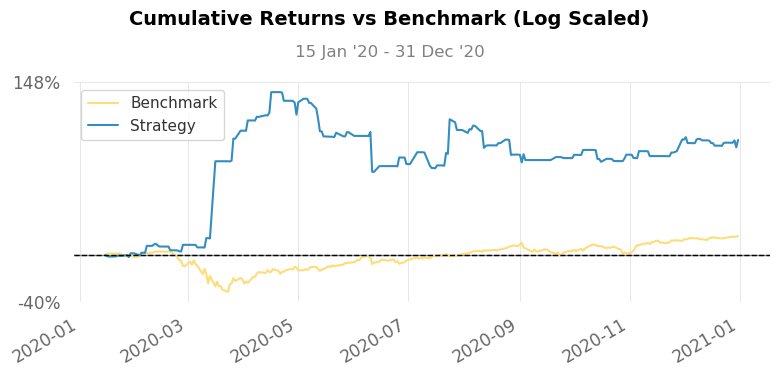

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


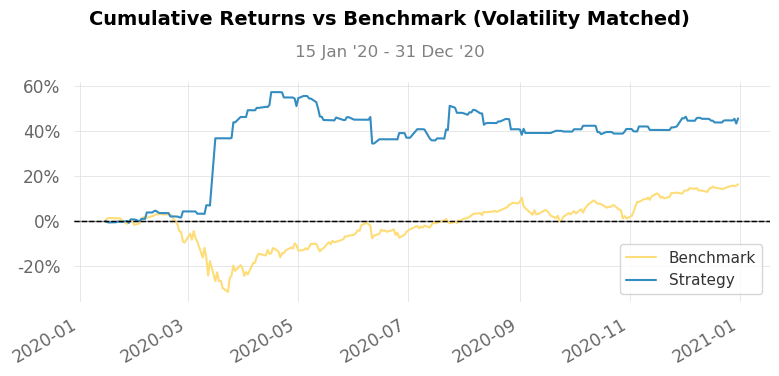

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


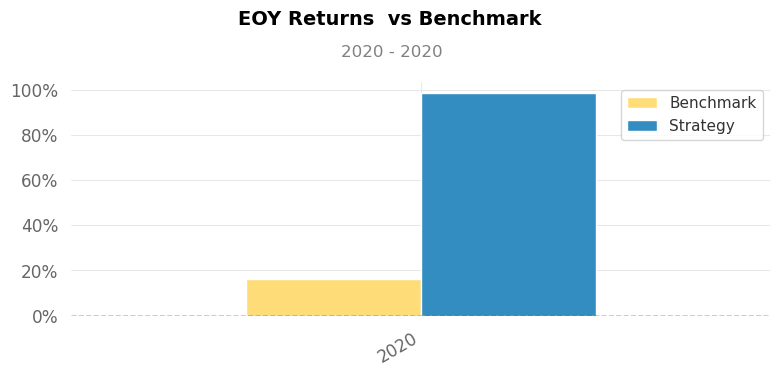

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


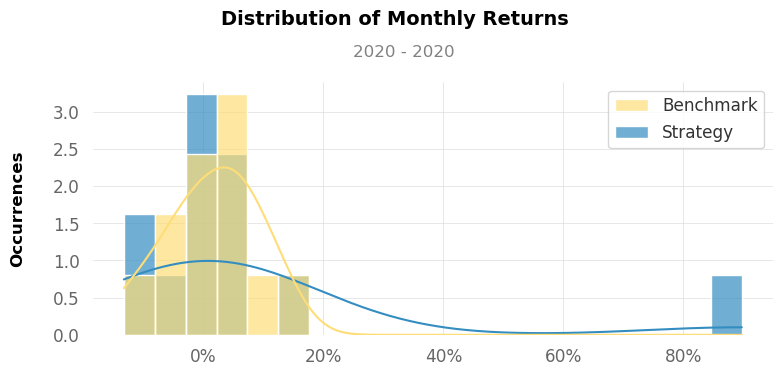

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


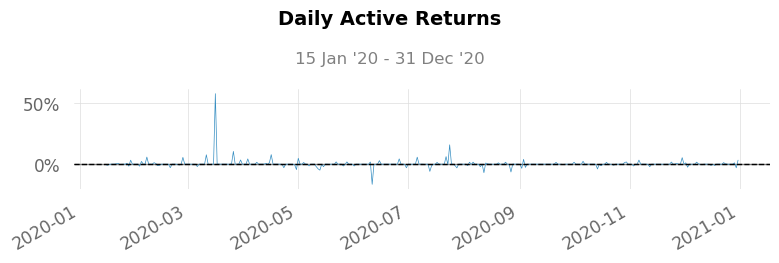

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


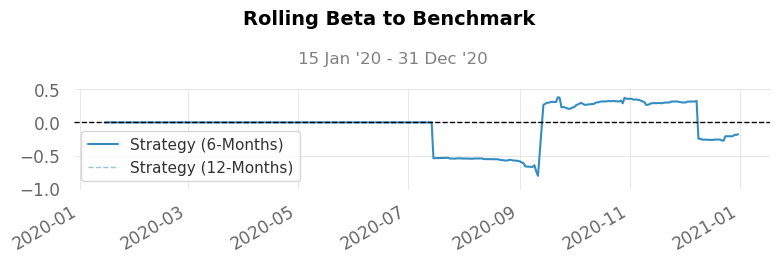

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


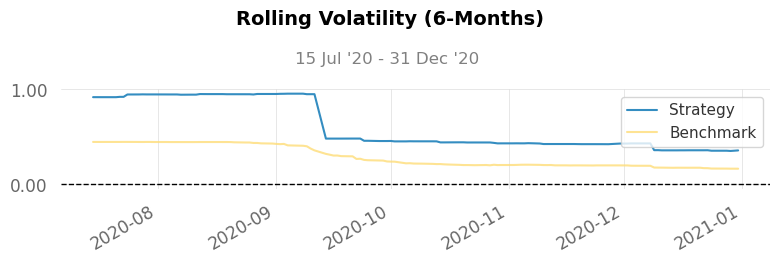

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


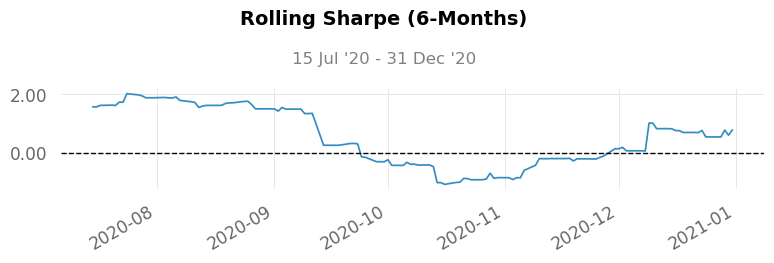

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


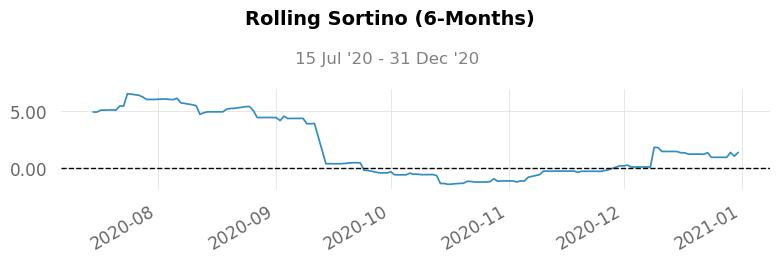

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


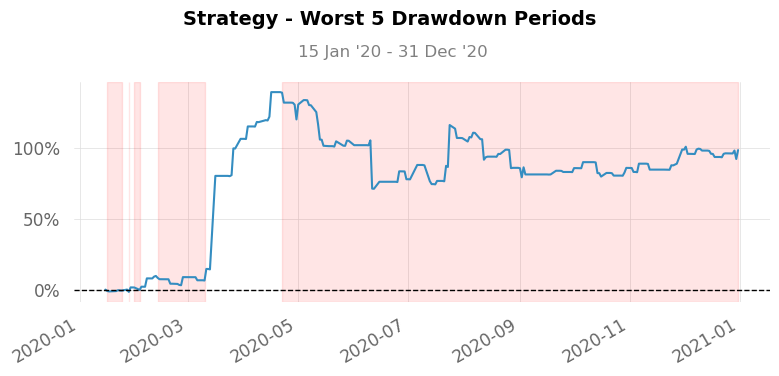

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


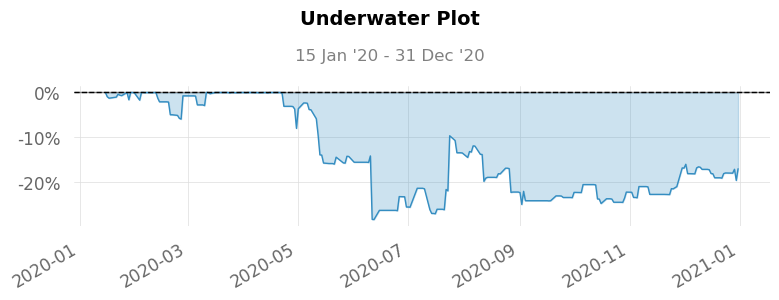

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


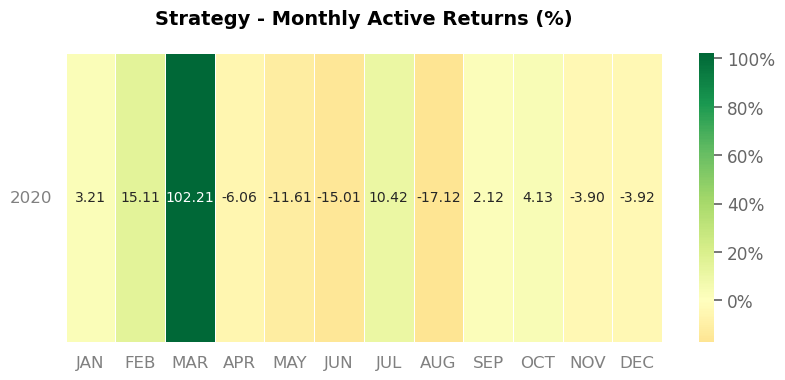

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


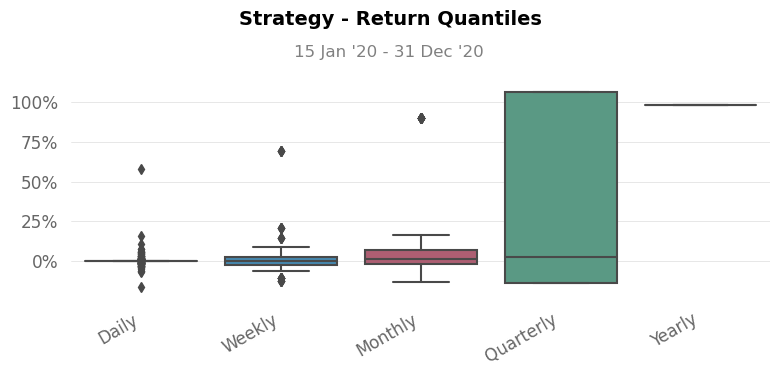

In [201]:
# Explanation: This script generates quantitative analysis reports using the `quantstats` library.
# It compares the strategy's returns with the benchmark returns, providing insights into performance.

start = result.index[0]
end = result.index[-1]

# Download benchmark data (e.g., S&P 500 - SPY)
benchmark = yf.download('SPY', start=start, end=end)['Adj Close'].pct_change()

# Adjust result index and benchmark index for proper alignment
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index

# Generate quantitative analysis reports using quantstats
qs.reports.full(result['returns'], benchmark=benchmark, match_dates=True, figsize=(8, 4), df=result)


## Summary of the Performance

-----------------------------------------------------------------------------------------------------------------------------------
The strategy did really well compared to the benchmark. It made a lot more money, nearly 98.39% versus the benchmark's 16.31%. Even when considering risk, the strategy seems smart, especially with a higher Sharpe ratio (1.29) showing good returns for the risk taken. It also handled tough times better, with a smaller drop (max drawdown of -28.5%) compared to the benchmark (-33.72%). So, it looks like the strategy is doing a good job, even though it may have a bit more ups and down.


## MACD Strategy Implementation

This is a trend-following strategy that uses the MACD indicator. The MACD can be used to show the momentum of a trend.So, the strategy goes like this:

1. A buy signal forms if the MACD line crosses above the signal line and is rising.
2. A sell signal forms if the MACD line crosses below the signal line and is descending.

In [202]:
def initialize(context):
    """
    Initialize the MACD trading strategy context.

    Args:
        context (zipline.api.TradingAlgorithm): The trading strategy context.
    """
    context.i = 0
    context.assets = assets
    context.macd_short_window = 5
    context.macd_long_window = 17
    context.macd_signal_window = 5
    context.max_window = 17

def exec_trade(data, positions):
    """
    Execute trades for the specified positions.

    Args:
        data (zipline.api.BarData): The bar data for the current trading day.
        positions (dict): Dictionary containing asset and target percent for trading.

    Returns:
        None
    """
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

def calculate_macd(prices, short_window, long_window, signal_window):
    """
    Calculate MACD and signal line.

    Args:
        prices (pd.Series): Historical prices.
        short_window (int): Short-term window for MACD calculation.
        long_window (int): Long-term window for MACD calculation.
        signal_window (int): Window for signal line calculation.

    Returns:
        pd.Series: MACD values.
        pd.Series: Signal line values.
    """
    exp12 = prices.ewm(span=short_window, adjust=False).mean()
    exp26 = prices.ewm(span=long_window, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def handle_data(context, data):
    """
    Execute trading logic based on MACD signals.

    Args:
        context (zipline.api.TradingAlgorithm): The trading strategy context.
        data (zipline.api.BarData): The bar data for the current trading day.

    Returns:
        None
    """
    context.i += 1
    if context.i < context.max_window:
        return
    buy_signal = False
    sell_signal = False
    
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.max_window + 1, frequency='1d')

        # Calculate MACD
        close_prices = prices[-context.macd_long_window:]
        macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            cash = context.portfolio.cash
            if macd.iloc[-1] > signal.iloc[-1] and macd.iloc[-2] < signal.iloc[-2]:
                target_percent = 1.0  # Long position
                buy_signal = True
            elif macd.iloc[-1] < signal.iloc[-1] and macd.iloc[-2] > signal.iloc[-2]:
                target_percent = -1.0  # Short position
                sell_signal = True
            else:
                target_percent = 0.0   # Close position
            exec_trade(data, {asset: target_percent})
        
        # Record the values for later analysis
        record(
            price=current_price,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices
        )


In [203]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

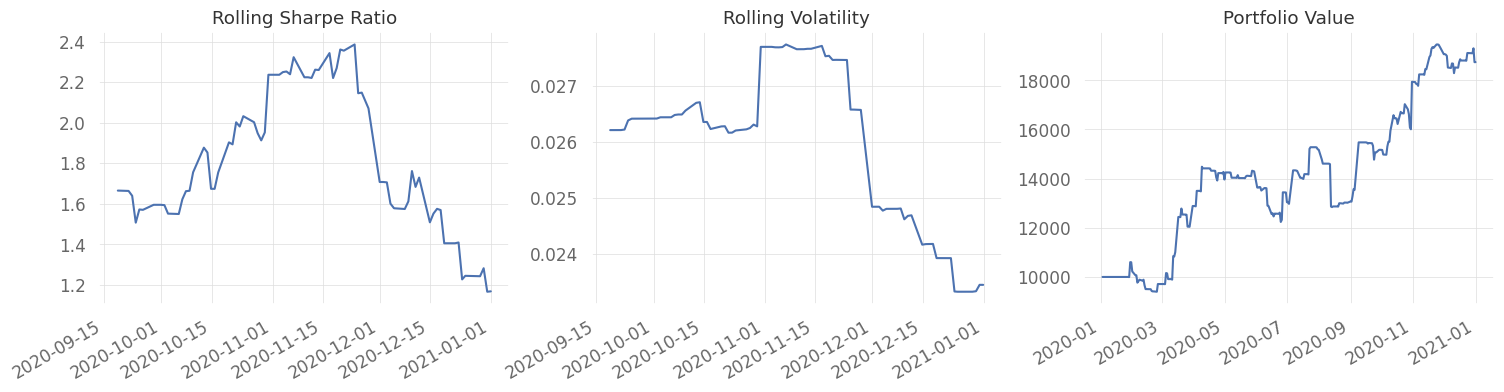

In [204]:
result = show_rolling_stats(result, 180)

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-28   2020-01-28
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       75.0%

Cumulative Return          17.73%       87.37%
CAGR﹪                     12.94%       59.7%

Sharpe                     0.68         1.87
Prob. Sharpe Ratio         74.11%       97.88%
Smart Sharpe               0.67         1.85
Sortino                    0.93         3.88
Smart Sortino              0.92         3.85
Sortino/√2                 0.66         2.74
Smart Sortino/√2           0.65         2.72
Omega                      1.71         1.71

Max Drawdown               -33.72%      -15.94%
Longest DD Days            170          104
Volatility (ann.)          34.47%       40.07%
R^2                        0.01         0.01
Information Ratio          0.06         0.06
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-07-29,2020-08-13,2020-09-04,38,-15.936856,-15.807347
2,2020-04-09,2020-06-24,2020-07-21,104,-15.509503,-14.899269
3,2020-01-30,2020-02-24,2020-03-10,41,-11.349898,-11.220734
4,2020-11-25,2020-12-10,2020-12-31,37,-5.996195,-4.920091
5,2020-10-26,2020-10-29,2020-10-29,4,-5.994181,-5.545369


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


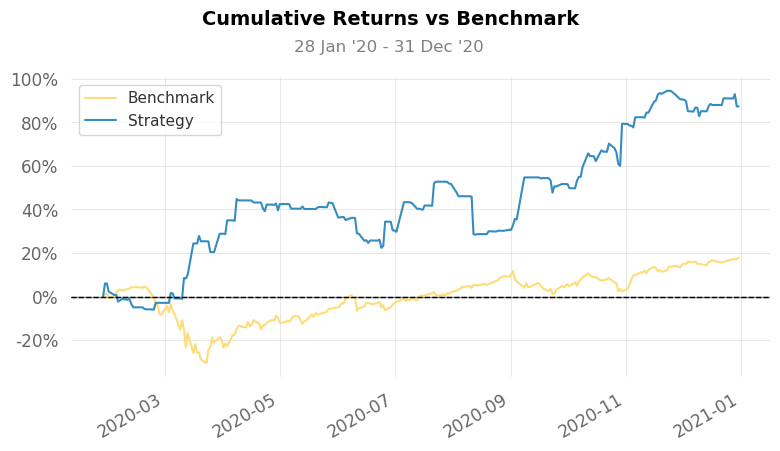

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


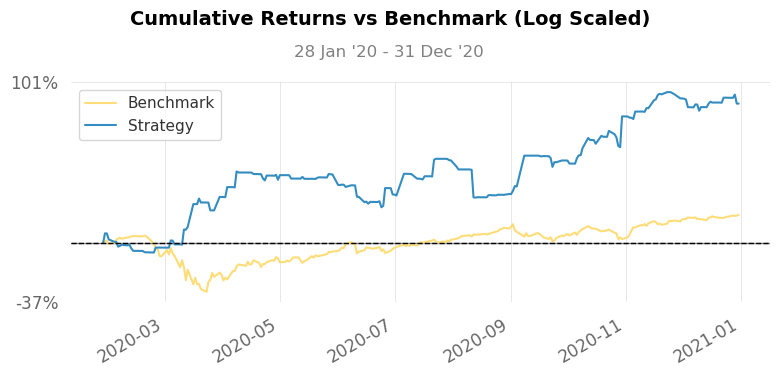

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


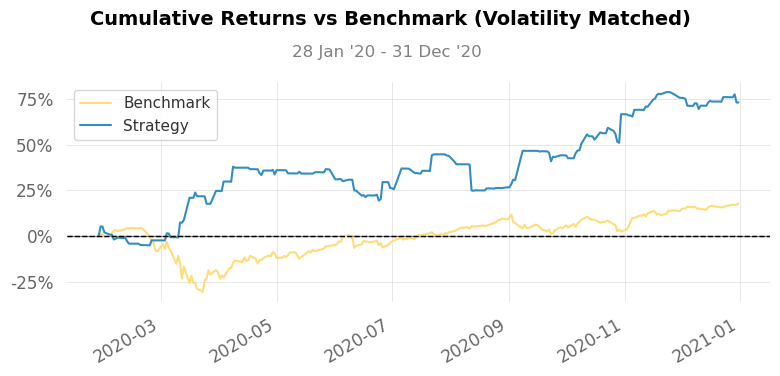

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


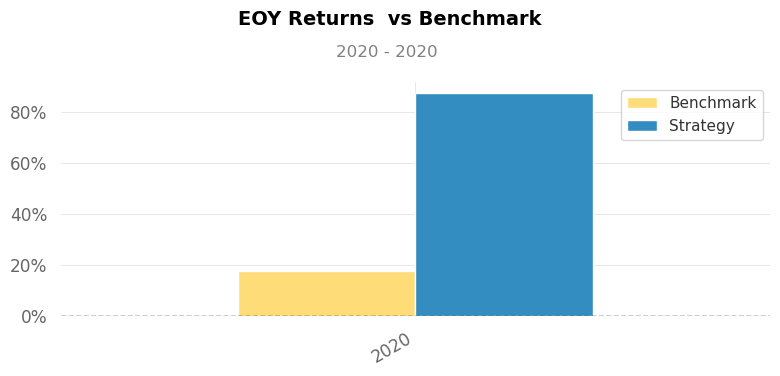

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


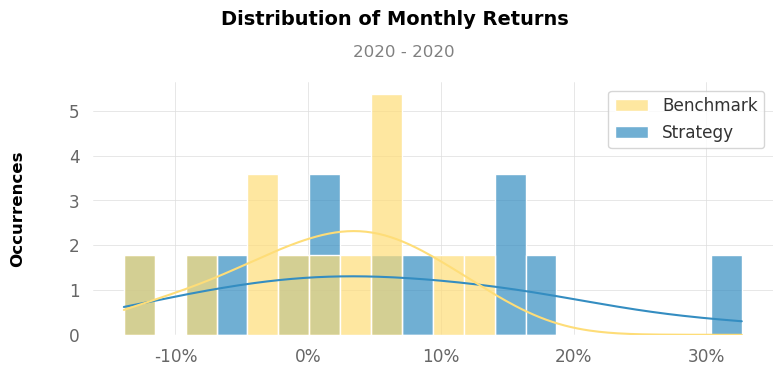

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


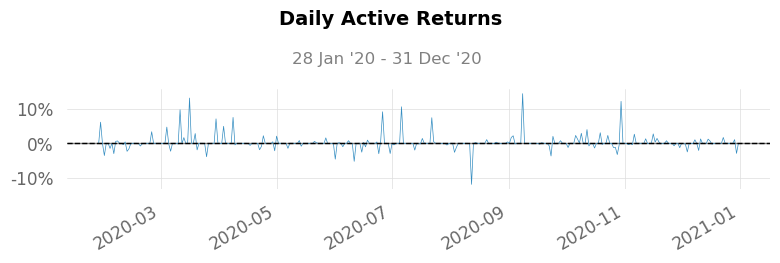

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


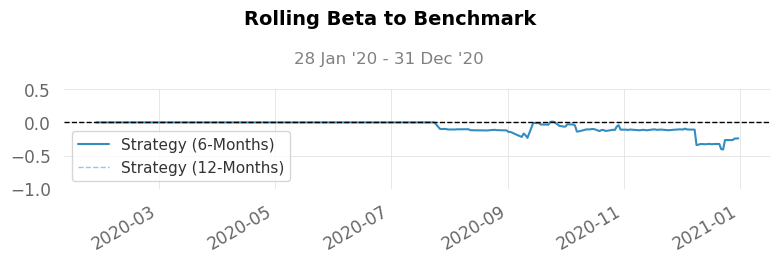

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


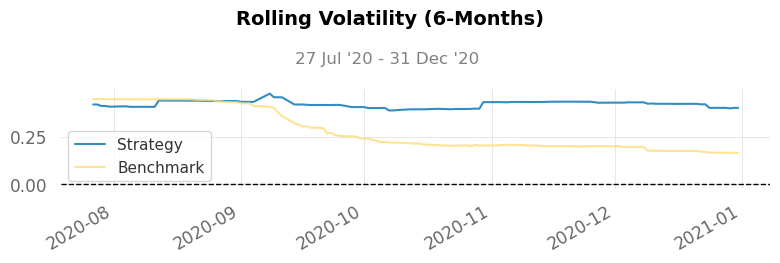

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


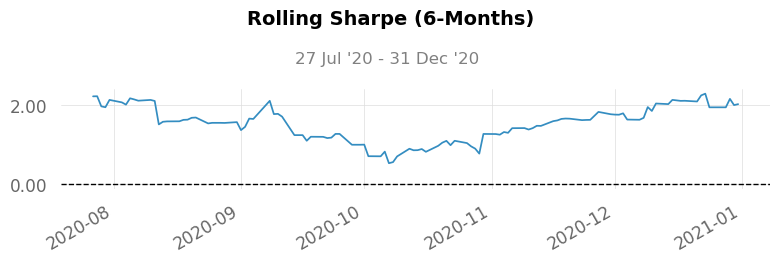

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


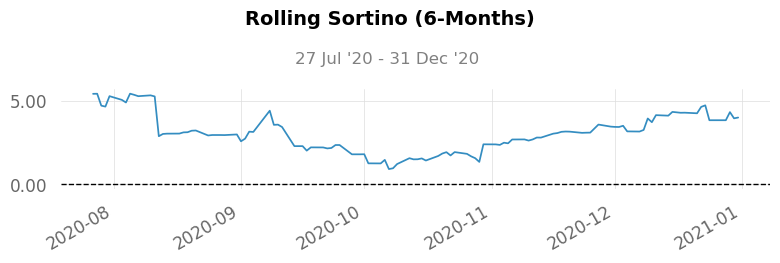

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


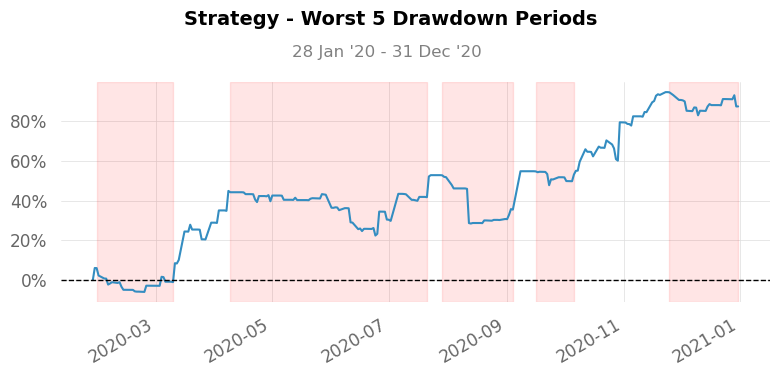

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


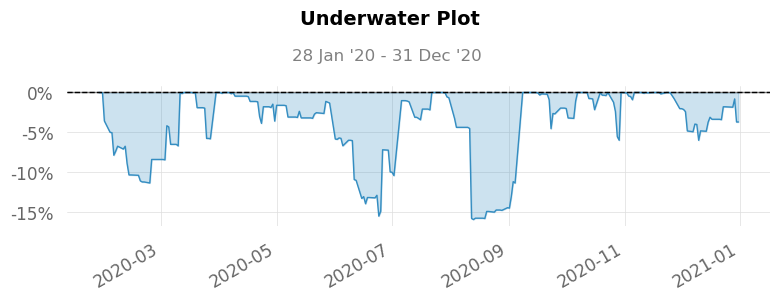

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


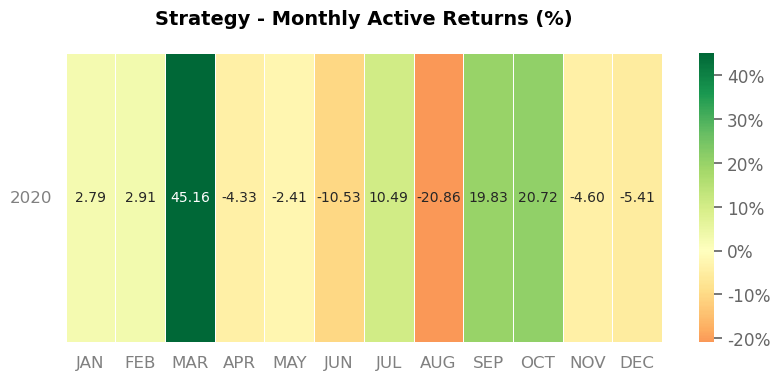

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


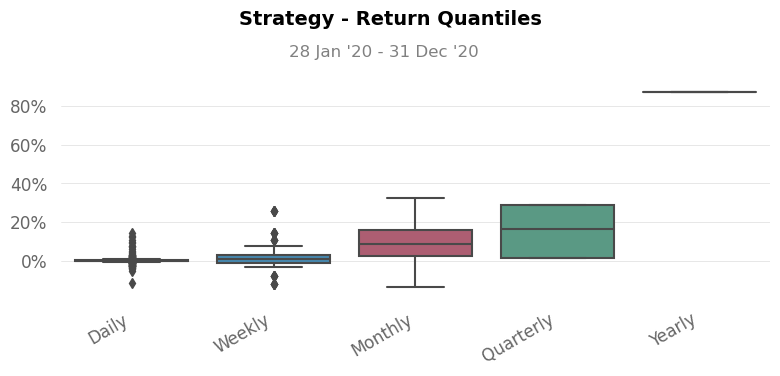

In [205]:
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)

## Summary Of the Performance

---------------------------------------------------------------------------------------------------------------------------------
The strategy did way better than the benchmark, making 87.37% versus 17.73% in total. It's like winning by a lot in a game. The strategy also handled risks smartly, with a big number called the Sharpe ratio at 1.87 (higher is better), way ahead of the benchmark at 0.68. When things got tough, the strategy didn't lose much, only 15.94%, while the benchmark lost a lot more at 33.72%. So, it's like the strategy is not only making more money but also playing it safe when things get rough. That's pretty cool!


## Combined Strategy Implementation (Bollinger Bands and MACD)

This is a trend-following strategy that combines the MACD indicator and the Bollinger Bands. Since the MACD can be used to show the momentum of a trend and the Bollinger Bands can show price breakouts, we can combine both to gauge the momentum of the market when the price is breaking out of the Bollinger Bands. So, the strategy goes like this:

1. A buy signal forms if the price break above the upper band and the MACD line crosses above the signal line and is rising.
2. A sell signal forms if the price break below the lower band and the MACD line crosses below the signal line and is descending.

In [206]:
def initialize(context):
    """
    Initialize the combined trading strategy context.

    Args:
        context (zipline.api.TradingAlgorithm): The trading strategy context.
    """
    context.i = 0
    context.assets = assets
    context.bollinger_window = 5  # Bollinger Bands window
    context.bollinger_dev = 1.5  # Number of standard deviations for Bollinger Bands
    context.macd_short_window = 5
    context.macd_long_window = 17
    context.macd_signal_window = 5
    context.max_window = 17

def exec_trade(data, positions):
    """
    Execute trades for the specified positions.

    Args:
        data (zipline.api.BarData): The bar data for the current trading day.
        positions (dict): Dictionary containing asset and target percent for trading.

    Returns:
        None
    """
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

def calculate_macd(prices, short_window, long_window, signal_window):
    """
    Calculate MACD and signal line.

    Args:
        prices (pd.Series): Historical prices.
        short_window (int): Short-term window for MACD calculation.
        long_window (int): Long-term window for MACD calculation.
        signal_window (int): Window for signal line calculation.

    Returns:
        pd.Series: MACD values.
        pd.Series: Signal line values.
    """
    exp12 = prices.ewm(span=short_window, adjust=False).mean()
    exp26 = prices.ewm(span=long_window, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def handle_data(context, data):
    """
    Execute trading logic based on combined Bollinger Bands and MACD signals.

    Args:
        context (zipline.api.TradingAlgorithm): The trading strategy context.
        data (zipline.api.BarData): The bar data for the current trading day.

    Returns:
        None
    """
    context.i += 1
    if context.i < context.max_window:
        return
    buy_signal = False
    sell_signal = False
    
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.max_window + 1, frequency='1d')
        # Calculate Bollinger Bands
        sma = prices[-context.bollinger_window:].mean()
        rolling_std = prices[-context.bollinger_window:].std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Calculate MACD
        close_prices = prices[-context.macd_long_window:]
        macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            cash = context.portfolio.cash
            # Generate signals based on Bollinger Bands and MACD
            if current_price > upper_band and macd.iloc[-1] > signal.iloc[-1]:
                target_percent = 1.0  # Long position
                buy_signal = True
            elif current_price < lower_band and macd.iloc[-1] < signal.iloc[-1]:
                target_percent = -1.0  # Short position
                sell_signal = True
            else:
                target_percent = 0.0   # Close position
            exec_trade(data, {asset: target_percent})
        
        # Record the values for later analysis
        record(
            price=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices
        )


In [207]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

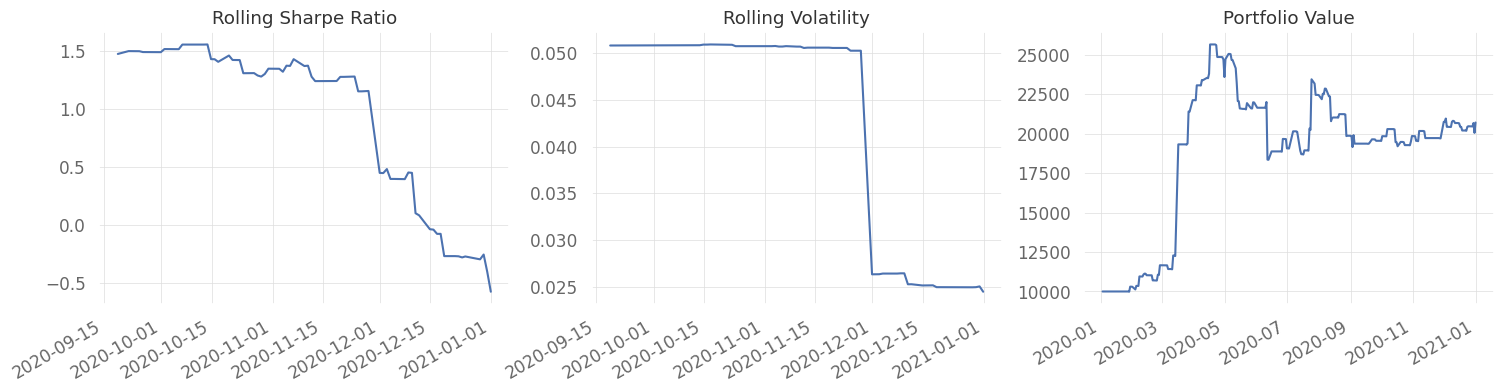

In [208]:
result = show_rolling_stats(result, 180)

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-28   2020-01-28
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       64.0%

Cumulative Return          17.73%       107.01%
CAGR﹪                     12.94%       72.02%

Sharpe                     0.68         1.38
Prob. Sharpe Ratio         74.11%       97.78%
Smart Sharpe               0.66         1.34
Sortino                    0.93         3.91
Smart Sortino              0.9          3.81
Sortino/√2                 0.66         2.77
Smart Sortino/√2           0.64         2.7
Omega                      1.83         1.83

Max Drawdown               -33.72%      -28.48%
Longest DD Days            170          254
Volatility (ann.)          34.47%       71.31%
R^2                        0.06         0.06
Information Ratio          0.05         0.05
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-04-22,2020-06-12,2020-12-31,254,-28.482259,-27.173894
2,2020-02-13,2020-02-24,2020-02-26,14,-3.940318,-3.847844
3,2020-03-05,2020-03-10,2020-03-10,6,-2.206835,-2.049449
4,2020-01-31,2020-02-03,2020-02-03,4,-1.717782,-0.050750
5,2020-03-13,2020-03-13,2020-03-13,1,-0.276508,NaN


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


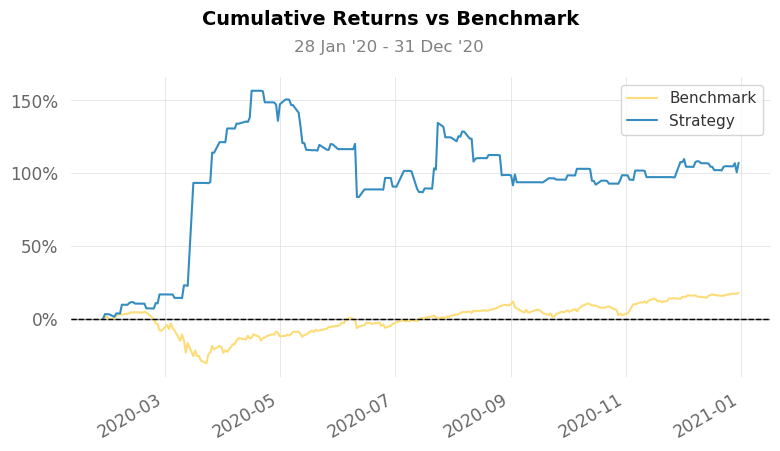

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


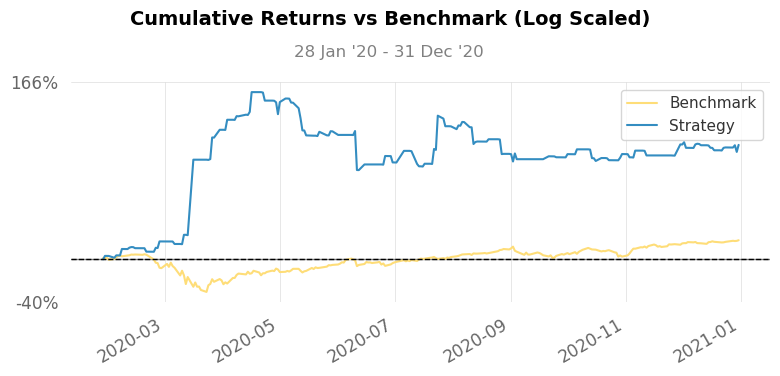

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


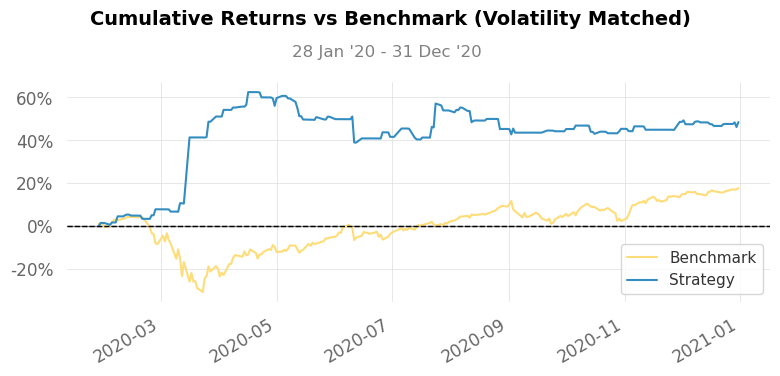

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


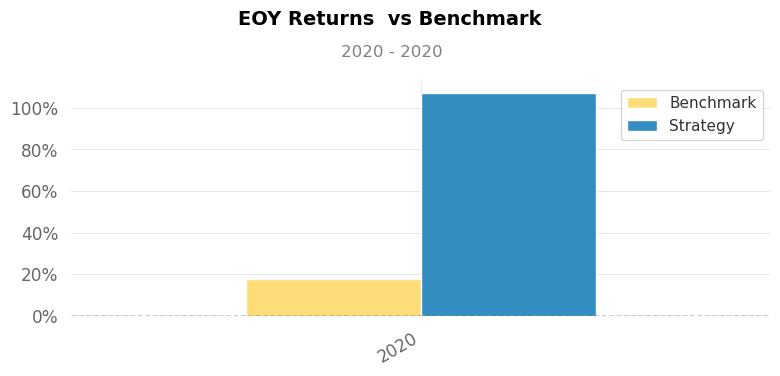

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


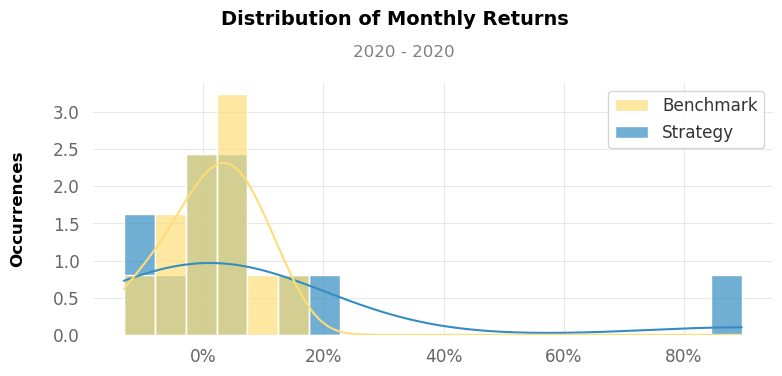

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


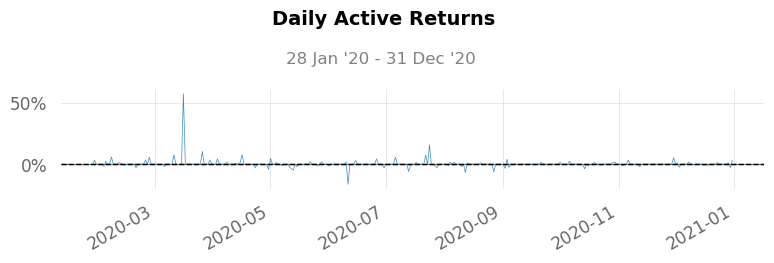

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


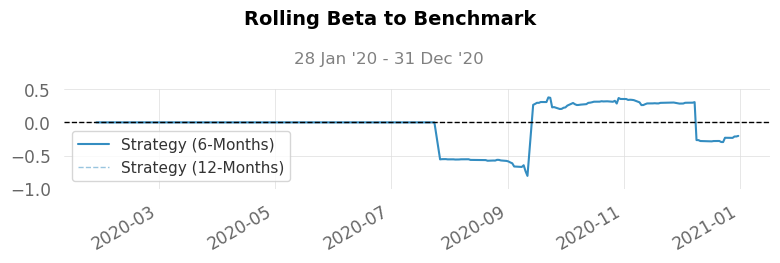

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


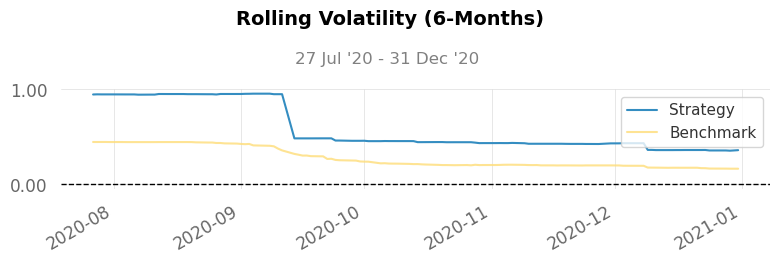

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


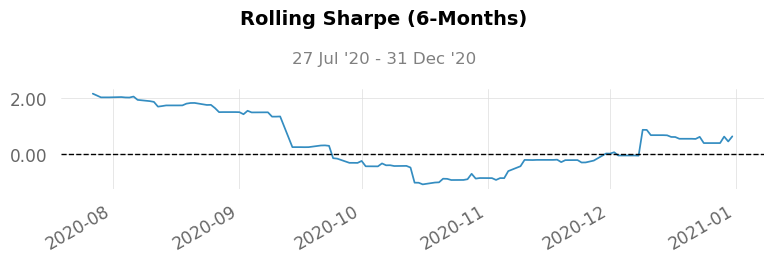

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


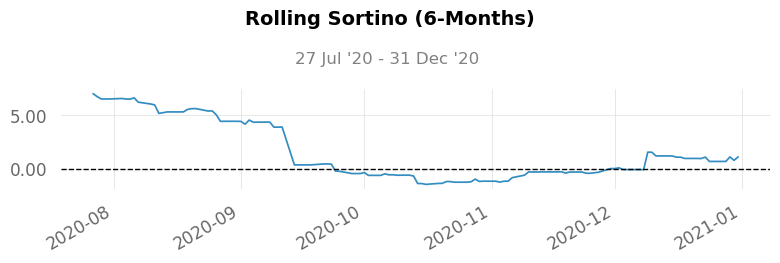

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


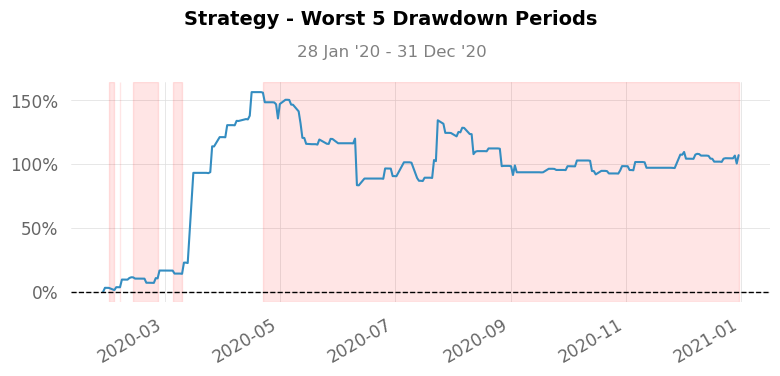

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


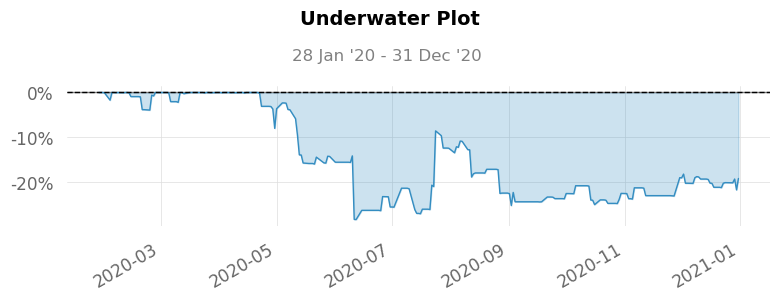

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


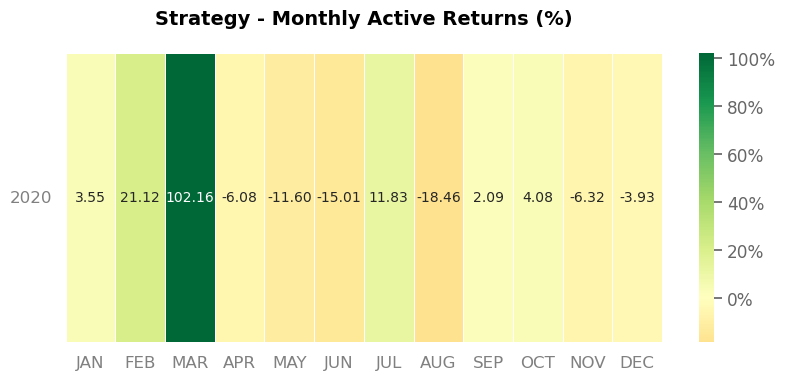

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


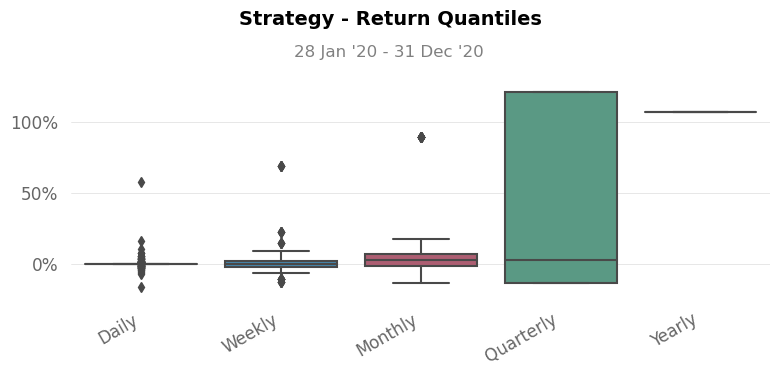

In [209]:
# start = result.index[0]
# end = result.index[-1]
# benchmark = yf.download('SPY', start=start, end=end)['Adj Close'].pct_change()
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)

## Summary of the performance

----------------------------------------------------------------------------------------------------------------------------------
The strategy did awesome! It made a lot more money, like 107.01%, while the benchmark only did 17.73%. Every year, it kept making around 72.02%, which is really good. The strategy is smart with risks too, scoring 1.38 on the Sharpe ratio (higher is better), way better than the benchmark at 0.68. Even when things got tough, the strategy didn't lose much, only 28.48%, while the benchmark lost more at 33.72%. So, the strategy not only makes more money but also plays it cool when things get tricky. That's a win-win!
